In [3]:
from lfads_tf2.utils import load_data, load_posterior_averages
import src.data
import src.lfads_helpers
import pyaldata
import yaml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import k3d
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')

In [5]:
with open('../params.yaml', 'r') as params_file:
    params = yaml.safe_load(params_file)['lfads_prep']

td_co = trial_data.groupby('task').get_group('CO')
td_co = pyaldata.combine_time_bins(td_co,int(params['bin_size']/td_co['bin_size'].values[0]))

trial_ids = load_data(
    '../data/pre-lfads/', 
    prefix='Earl_20190716_CO', 
    signal='trial_id',
    merge_tv=True)[0].astype(int)

post_data = load_posterior_averages('../results/autolfads/Earl_20190716/autolfads_with_jitter/co/', merge_tv=True)
td_co = src.lfads_helpers.add_lfads_rates(td_co, post_data.rates/params['bin_size'], chopped_trial_ids=trial_ids, overlap=params['overlap'], new_sig_name='lfads_rates')
td_co = src.lfads_helpers.add_lfads_rates(td_co, post_data.gen_inputs, chopped_trial_ids=trial_ids, overlap=params['overlap'], new_sig_name='lfads_gen_inputs')

td_co = src.data.trim_nans(td_co,ref_signals=['rel_hand_pos','lfads_rates'])
# td_co = src.data.fill_kinematic_signals(td_co)

td_co['M1_rates'] = [
    pyaldata.smooth_data(
        spikes/bin_size,
        dt=bin_size,
        std=0.05,
        backend='convolve',
    ) for spikes,bin_size in zip(td_co['M1_spikes'],td_co['bin_size'])
]
M1_pca_model = PCA()
td_co = pyaldata.dim_reduce(td_co,M1_pca_model,'M1_rates','M1_pca')

lfads_pca_model = PCA()
td_co = pyaldata.dim_reduce(td_co,lfads_pca_model,'lfads_rates','lfads_pca')

start_time = -0.4
end_time = 0.4
td_co = pyaldata.restrict_to_interval(
    td_co,
    start_point_name='idx_goCueTime',
    rel_start=int(start_time/td_co.loc[td_co.index[0],'bin_size']),
    rel_end=int(end_time/td_co.loc[td_co.index[0],'bin_size']),
    reset_index=False
)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  34  36  56  62  86  94 103 110 112 115 120
 137 139 146 157 159 161 165 181 200 224 225 229 230 239 244 249 254 261
 266 269 304 306 308 309 316 321 344 352 355 357 360 361 366 369 370 371
 376 378 384 386 388 393 394 399 403 404 405 408 409 411 413 416 420 422
 423 427 428 429 431 437 446 454 458 460 462 472 476 477 481 488 489 490
 492 500 508 509 512 516 519]


In [6]:

target_dirs = td_co['tgtDir'].unique()
dir_colors = plt.get_cmap('Dark2',8)
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='Neural Traces')
for dirnum,target_dir in enumerate(target_dirs):
    # plot traces
    color_val = int(255*dir_colors(dirnum)[0]) << 16 | int(255*dir_colors(dirnum)[1]) << 8 | int(255*dir_colors(dirnum)[2])
    td_co_dir = td_co.loc[np.isclose(td_co['tgtDir'],target_dir)]
    for neural_trace in td_co_dir['M1_pca'].sample(n=25):
        trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,color=color_val)
    
    trace_plot+=k3d.line(td_co_dir['M1_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=color_val)

trace_plot.display()

Output()

In [7]:
target_dirs = td_co['tgtDir'].unique()
dir_colors = plt.get_cmap('Dark2',8)
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='LFADS Traces')
for dirnum,target_dir in enumerate(target_dirs):
    # plot traces
    color_val = int(255*dir_colors(dirnum)[0]) << 16 | int(255*dir_colors(dirnum)[1]) << 8 | int(255*dir_colors(dirnum)[2])
    td_co_dir = td_co.loc[np.isclose(td_co['tgtDir'],target_dir)]
    for neural_trace in td_co_dir['lfads_pca'].sample(n=25):
        trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,color=color_val)
    
    trace_plot+=k3d.line(td_co_dir['lfads_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=color_val)

trace_plot.display()


Output()

: 

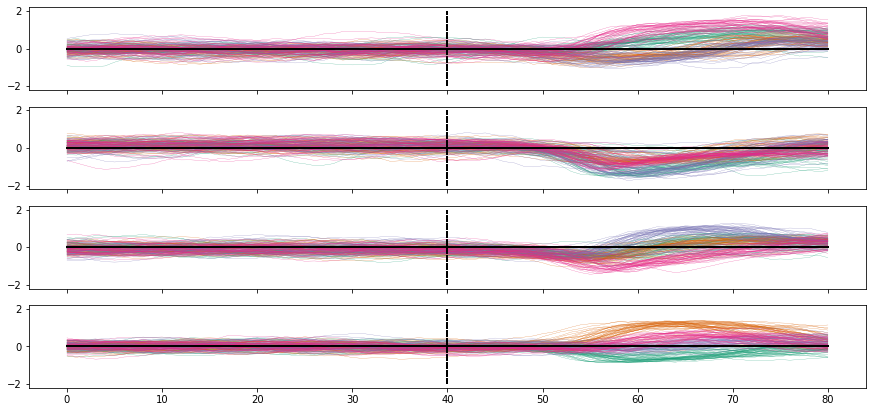

In [23]:
fig,axs = plt.subplots(4,1,figsize=(15,7),sharex=True)

target_dirs = td_co['tgtDir'].unique()
dir_colors = plt.get_cmap('Dark2',8)
# fig,ax = plt.subplots()
for dirnum,target_dir in enumerate(target_dirs):
    td_co_dir = td_co.loc[np.isclose(td_co['tgtDir'],target_dir)]
    for _,trial in td_co_dir.iterrows():
        for plotnum,ax in enumerate(axs):
            ax.plot(trial['lfads_gen_inputs'][:,plotnum],color=dir_colors(dirnum),lw=0.2)
            ax.plot([0,80],[0,0],'k-')
            ax.plot(trial['idx_goCueTime']*np.ones((2,)),[-2,2],'k--')